# Trực quan hóa dữ liệu 

Notebook này trực quan hóa bộ `processed_data.csv` (World Bank 2000-2024) để nhanh chóng nắm bắt sự thay đổi về tăng trưởng kinh tế, chất lượng sống,... và các yếu tố khác.

Notebook này làm việc trực tiếp với dữ liệu gốc (chưa chuẩn hoá) nhằm giữ lại và thể hiện rõ phân phối, đặc tính của các thuộc tính trong thực tế.


## Mục tiêu
- Tóm tắt cấu trúc dữ liệu sau bước tiền xử lý.
- Minh họa các xu hướng chính bằng những biểu đồ quen thuộc của `seaborn` và `matplotlib`.
- Khám phá những insight quan trọng thu được từ  biểu đồ.


## Quy trình thực hiện
1. Chuẩn bị môi trường (thư viện, theme đồ họa).
2. Đọc dữ liệu đã làm sạch và rà soát sơ bộ.
3. Dựng từng nhóm biểu đồ (kinh tế, phúc lợi, hạ tầng, môi trường) kèm giải thích chi tiết.
4. Tổng hợp insight và tổng kết.


## Bước 1 - Chuẩn bị môi trường
Import các thư viện nền tảng và thiết lập style tối giản để biểu đồ nhất quán giữa các bước.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.dpi"] = 120
pd.options.display.float_format = lambda x: f"{x:,.2f}"

DATA_PATH = Path("../data/processed/processed_data.csv")
DATA_PATH


WindowsPath('../data/processed/processed_data.csv')

## Bước 2 - Đọc dữ liệu


In [2]:
df = pd.read_csv(DATA_PATH)

df["year"] = df["year"].astype(int)

print(f"Số dòng: {df.shape[0]}\nSố cột: {df.shape[1]}")
df.head()

Số dòng: 5208
Số cột: 13


,country_name,country_code,year,population,pop_growth,life_expectancy,gdp_per_capita,gdp_growth,sanitation,electricity,water_access,co2_emissions,labor_force
0,Aruba,ABW,2000,"90,588.00",1.03,72.94,"20,681.02",7.62,55.11,91.70,95.23,2.97,61.14
1,Aruba,ABW,2001,"91,439.00",0.94,73.04,"20,740.13",4.18,57.81,100.00,95.36,2.97,61.14
2,Aruba,ABW,2002,"92,074.00",0.69,73.14,"21,307.25",-0.94,59.47,100.00,95.48,3.23,61.14
3,Aruba,ABW,2003,"93,128.00",1.14,73.24,"21,949.49",1.11,59.72,100.00,95.61,3.68,61.14
4,Aruba,ABW,2004,"95,138.00",2.14,73.22,"23,700.63",7.29,58.68,100.00,95.74,3.67,61.14


## Bước 3 - Khoanh vùng các biến quan trọng quyết định tới tuổi thọ


### 3.1. Vẽ ma trận tương quan giữa các thuộc tính

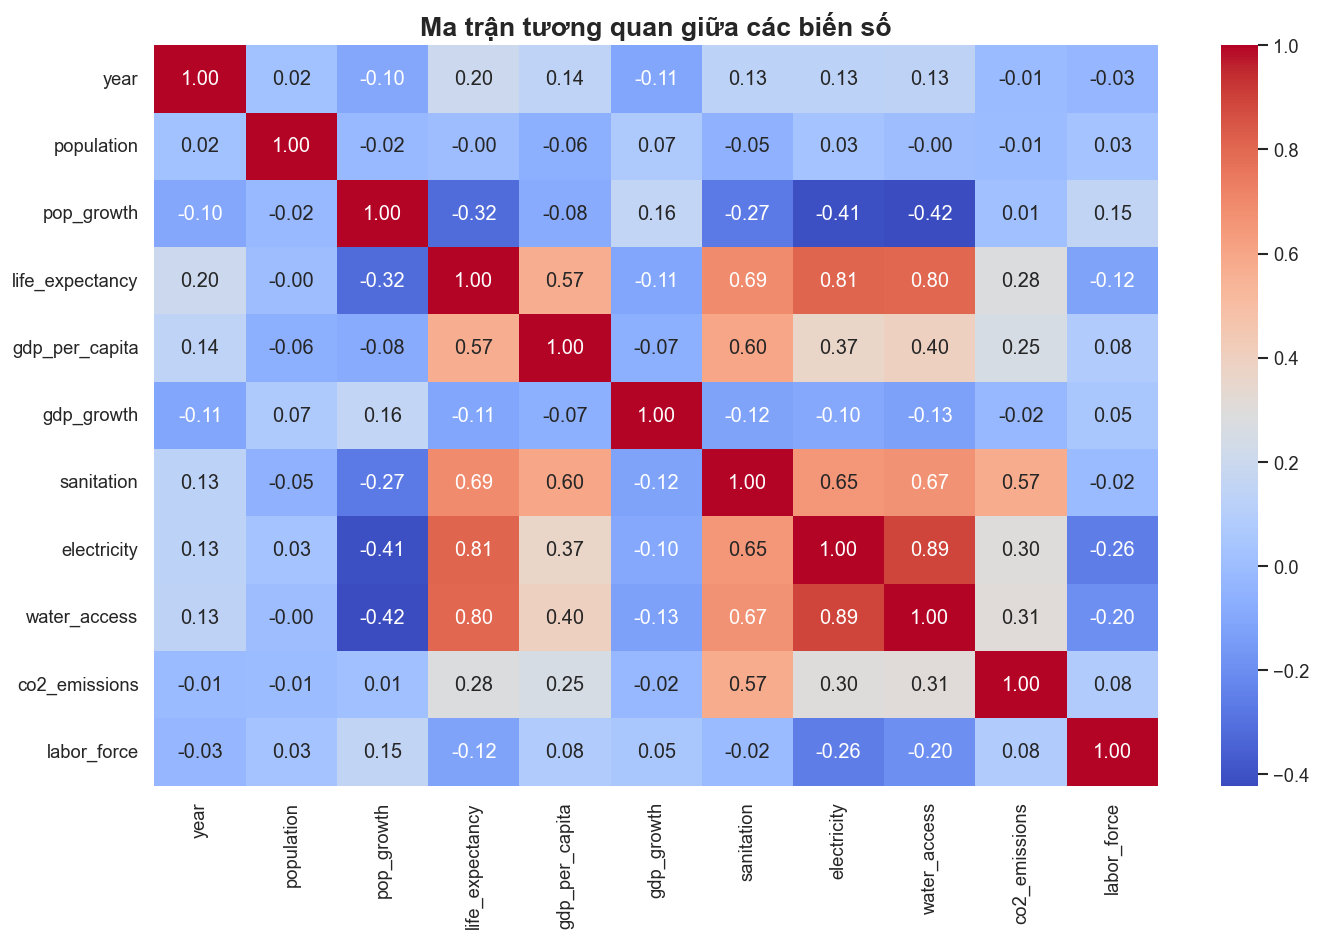

In [3]:
# Hiển thị heatmap tương quan để phục vụ việc lựa chọn biến dự đoán
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Ma trận tương quan giữa các biến số", fontsize=16, fontweight='bold')
plt.tight_layout()

### Nhận xét:

- Các biến `electricity`, `water_access`, `sanitation` và `gdp_per_capital` có chỉ số tương quan lớn với biến mục tiêu life_expectancy. Do đó, ta sẽ tập trung đi phân tích các biến này.

- Các biến hạ tầng có tương quan cao với nhau: `electricity`, `water_access` và `sanitation`. 
Điều này cho thấy: Các quốc gia có hạ tầng tốt (điện, nước, vệ sinh) thường có tuổi thọ cao hơn, và những nước đó có tăng trưởng dân số thấp hơn (cả 3 biến này đều có tương quan âm với `pop_growth`).

In [4]:
# Tính correlation matrix và quantiles cho các biến sẽ phân tích
life_corr_matrix = df.select_dtypes(include=[np.number]).corr()
gdp_quantiles = df["gdp_per_capita"].quantile([0.10, 0.50, 0.90])
life_quantiles = df["life_expectancy"].quantile([0.10, 0.50, 0.90])
corr_gdp_life = float(life_corr_matrix.loc["gdp_per_capita", "life_expectancy"])

print("Quantiles đã tính - sẵn sàng cho phần phân tích phân phối")


Quantiles đã tính - sẵn sàng cho phần phân tích phân phối


### 3.2. Kiểm tra phân phối của các chỉ số hạ tầng cơ bản
Vẽ histogram + KDE cho `electricity`, `water_access`, `sanitation` (các thuộc tính thể hiện các chỉ số hạ tầng cơ bản) để quan sát phân phối và độ lệch dữ liệu.


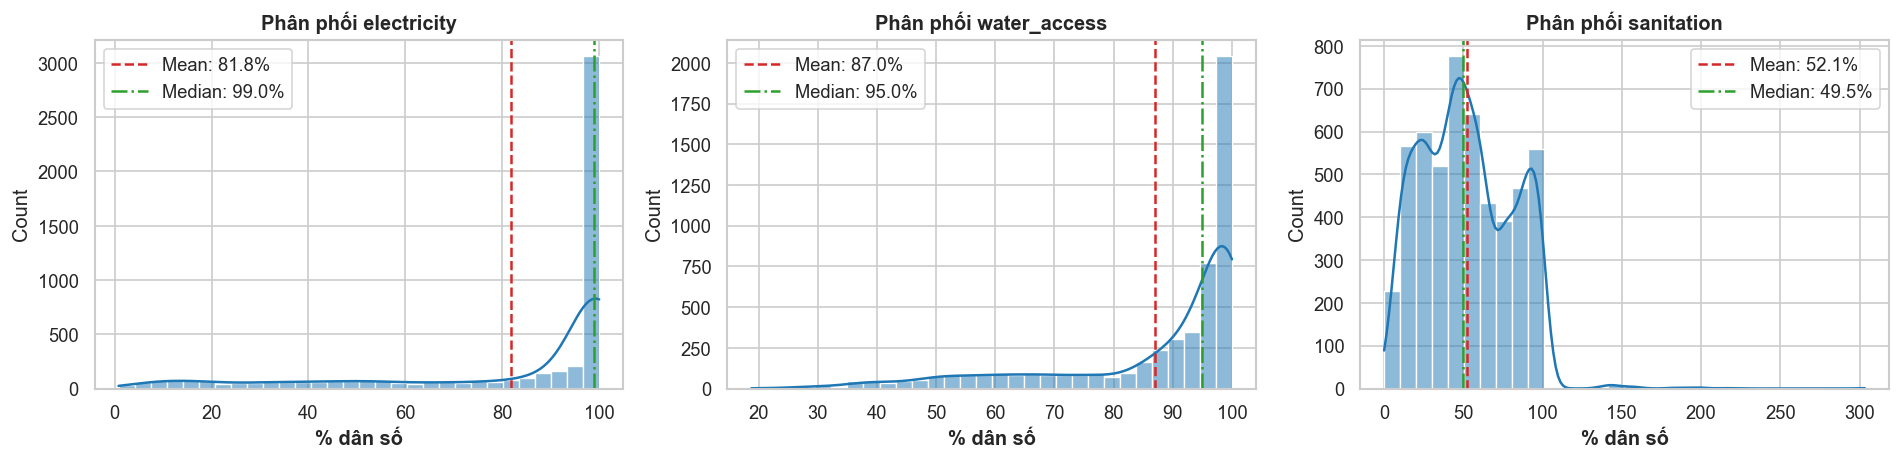

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

for ax, indicator in zip(axes, ['electricity', 'water_access', 'sanitation']):
    sns.histplot(df[indicator], bins=30, kde=True, ax=ax, color='#1f77b4')
    mean_val = df[indicator].mean()
    median_val = df[indicator].median()
    ax.axvline(mean_val, color='#d62728', linestyle='--', label=f'Mean: {mean_val:.1f}%')
    ax.axvline(median_val, color='#2ca02c', linestyle='-.', label=f'Median: {median_val:.1f}%')
    ax.set_title(f'Phân phối {indicator}', fontweight='bold')
    ax.set_xlabel('% dân số', fontweight='bold')
    ax.legend()

plt.tight_layout()


### Nhận xét:
- **Electricity**: Phân phối lệch trái rất lớn, hầu hết quốc gia (>2000) có độ phủ từ 95-100%, chỉ một số ít quốc gia dưới 50%. Mean=81.8% nhưng Median=99.0% cho thấy điện đã gần như phổ cập toàn cầu.
- **Water access**: Tương tự electricity, phân phối lệch trái, Mean=87.0%, Median=95.0%. Hầu hết quốc gia tiếp cận được nước sạch, nhưng vẫn có nhóm quốc gia có độ phủ dưới 50%.
- **Sanitation**: Phân phối hai đỉnh (bimodal), Mean=52.1%, Median=49.5%. Chỉ một nửa dân số thế giới có tiếp cận dịch vụ vệ sinh an toàn, đây là **nút thắt lớn nhất** giữa ba chỉ số hạ tầng cơ bản.

### 3.4. Phân phối GDP bình quân đầu người
Tại bước này, ta sử dụng biểu đồ histogram để thể hiện phân phối của GDP bình quân đầu người (`GDP per capita`). Thêm các đường phần trăm (10/50/90) để thể hiện rõ sự chênh lệch thu nhập giữa các nhóm quốc gia.


In [6]:
# Tính sẵn insight_stats để sử dụng trong biểu đồ
latest_year = int(df["year"].max())
baseline_year = int(df["year"].min())

insight_stats = {
    "gdp_q10": float(gdp_quantiles.loc[0.10]),
    "gdp_q50": float(gdp_quantiles.loc[0.50]),
    "gdp_q90": float(gdp_quantiles.loc[0.90]),
    "life_q10": float(life_quantiles.loc[0.10]),
    "life_q50": float(life_quantiles.loc[0.50]),
    "life_q90": float(life_quantiles.loc[0.90]),
    "corr_gdp_life": corr_gdp_life,
    "latest_year": latest_year,
    "baseline_year": baseline_year,
    "country_count": int(df["country_name"].nunique()),
}
print("insight_stats đã tính sẵn cho distribution analysis")


insight_stats đã tính sẵn cho distribution analysis


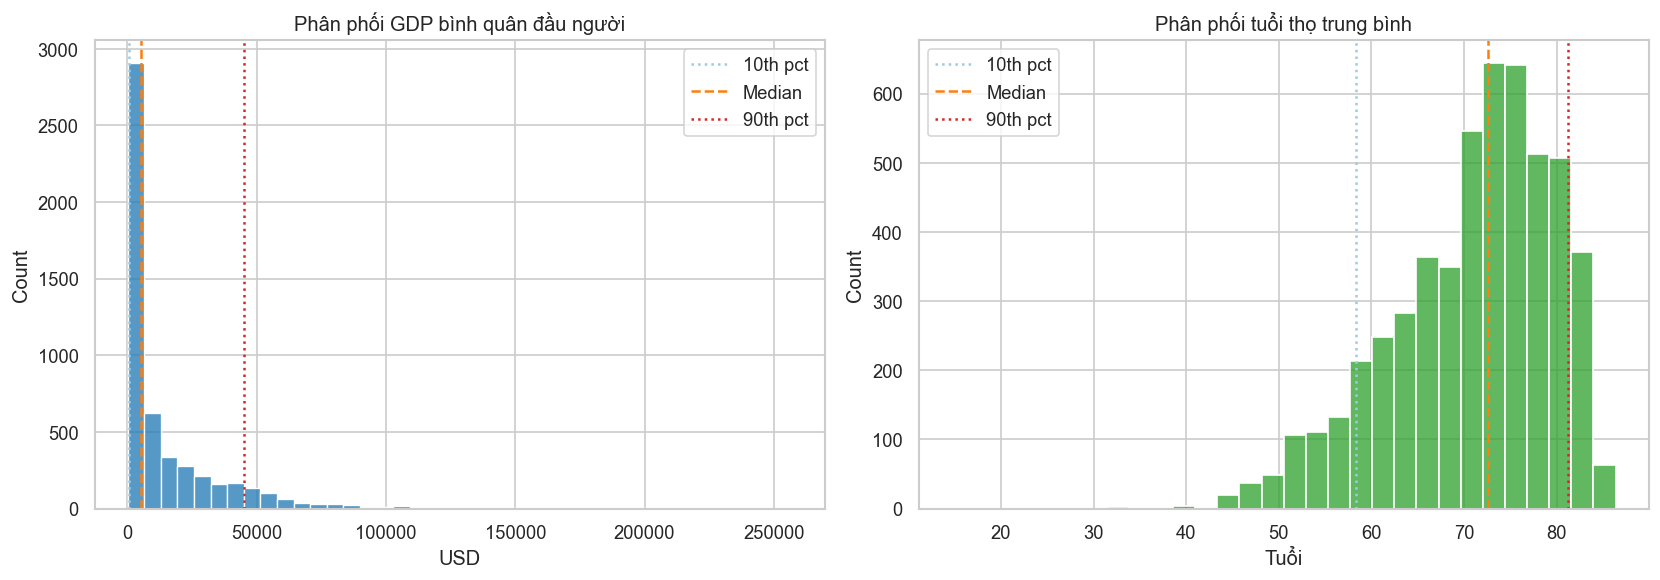

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(df["gdp_per_capita"], bins=40, ax=ax, color="#1f77b4")
ax.axvline(insight_stats["gdp_q10"], color="#9ecae1", linestyle=":", label="10th pct")
ax.axvline(insight_stats["gdp_q50"], color="#ff7f0e", linestyle="--", label="Median")
ax.axvline(insight_stats["gdp_q90"], color="#d62728", linestyle=":", label="90th pct")
ax.set_title("Phân phối GDP bình quân đầu người", fontweight='bold')
ax.set_xlabel("USD")
ax.legend()

plt.tight_layout()


### Insight - Phân phối GDP bình quân đầu người:
- **Phân phối cực kỳ lệch phải**: 10% quốc gia dưới ~800 USD, Median ~4,900 USD, trong khi 10% top >45,000 USD. **Khoảng cách lên tới 56 lần**.
- **Tập trung quanh 0-5,000 USD**: Hầu hết quốc gia có GDP thấp, cho thấy đa số thế giới vẫn còn khá nghèo.
- **Tail dài về bên phải**: Nhóm quốc gia giàu (>50,000 USD) là nhóm thiểu số nhưng nổi bật.

### 3.5. Phân phối tuổi thọ trung bình
Tiếp tục phân tích phân phối của biến mục tiêu `life_expectancy` để hiểu rõ sự chênh lệch về tuổi thọ giữa các quốc gia.


### Insight - Phân phối tuổi thọ trung bình:
- **Phân phối gần chuẩn nhưng lệch trái nhẹ**: Tập trung quanh 65-80 tuổi, với **Median ~72.6 tuổi**.
- **Khoảng cách**: 10% quốc gia dưới ~59 tuổi (tuổi thọ kém), 10% top >81 tuổi (tuổi thọ tốt). **Khoảng cách 22 tuổi** cho thấy sự chênh lệch y tế/hạ tầng vẫn rất lớn.
- **Nhóm nguy hiểm**: Quốc gia có tuổi thọ <50 tuổi (không phổ biến nhưng tồn tại) thường là các quốc gia vùng dịch bệnh hoặc xung đột.


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(df["life_expectancy"], bins=30, ax=ax, color="#2ca02c")
ax.axvline(insight_stats["life_q10"], color="#9ecae1", linestyle=":", label="10th pct")
ax.axvline(insight_stats["life_q50"], color="#ff7f0e", linestyle="--", label="Median")
ax.axvline(insight_stats["life_q90"], color="#d62728", linestyle=":", label="90th pct")
ax.set_title("Phân phối tuổi thọ trung bình", fontweight='bold')
ax.set_xlabel("Tuổi")
ax.legend()

plt.tight_layout()


### Insight - Phân phối tuổi thọ trung bình:
- **Phân phối gần chuẩn nhưng lệch trái nhẹ**: Tập trung quanh 65-80 tuổi, với **Median ~72.6 tuổi**.
- **Khoảng cách**: 10% quốc gia dưới ~59 tuổi (tuổi thọ kém), 10% top >81 tuổi (tuổi thọ tốt). **Khoảng cách 22 tuổi** cho thấy sự chênh lệch y tế/hạ tầng vẫn rất lớn.
- **Nhóm nguy hiểm**: Quốc gia có tuổi thọ <50 tuổi (không phổ biến nhưng tồn tại) thường là các quốc gia vùng dịch bệnh hoặc xung đột.


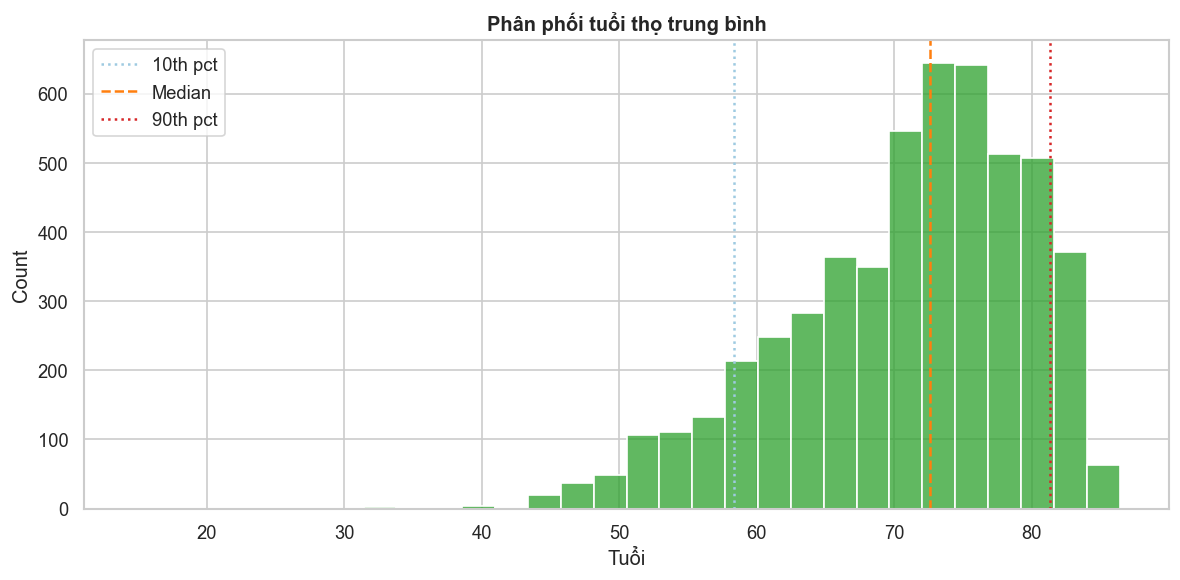

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.histplot(df["life_expectancy"], bins=30, ax=ax, color="#2ca02c")
ax.axvline(insight_stats["life_q10"], color="#9ecae1", linestyle=":", label="10th pct")
ax.axvline(insight_stats["life_q50"], color="#ff7f0e", linestyle="--", label="Median")
ax.axvline(insight_stats["life_q90"], color="#d62728", linestyle=":", label="90th pct")
ax.set_title("Phân phối tuổi thọ trung bình", fontweight='bold')
ax.set_xlabel("Tuổi")
ax.legend()

plt.tight_layout()


### 3.3. Xây dựng các bảng dữ liệu hỗ trợ cho việc phân tích

Ta tiến hành gộp dữ liệu hiện có theo năm, giữ lại giá trị các biến có mối tương quan cao với biến mục tiêu là `electricity`, `water_access`, `sanitation` và `gdp_per_capita`.

**Lý do dùng median thay vì mean**: 
Như phần phân tích phân phối ở trên cho thấy:
- **GDP** có phân phối cực kỳ lệch phải (56 lần chênh lệch giữa 10th-90th percentile)
- **Tuổi thọ** cũng có sự chênh lệch lớn (22 tuổi)
- **Hạ tầng** (electricity, water, sanitation) phân phối lệch trái hoặc hai đỉnh

Khi phân phối dữ liệu lệch, **median** (trung vị) là thước đo tập trung tốt hơn mean (trung bình cộng) vì nó **không bị ảnh hưởng bởi các giá trị ngoại lai cực đoan**. Vì vậy, ta gộp theo trung vị (median) của từng biến để xây dựng các bảng hỗ trợ.

In [10]:
# Bảng tổng hợp giữa điện, nước và vệ sinh (dùng median theo năm để giảm ảnh hưởng outlier)
services_trend = (
    df.groupby("year")[['electricity', 'water_access', 'sanitation']]
      .median()
      .reset_index()
      .melt(id_vars="year", var_name="indicator", value_name="coverage")
)

# Xu hướng median GDP theo năm
gdp_trend = (
    df.groupby("year")[ ["gdp_per_capita"] ]
      .median()
      .reset_index()
      .rename(columns={"gdp_per_capita": "median_gdp_per_capita"})
)

latest_year = int(df["year"].max())
baseline_year = int(df["year"].min())

# Top 10 nước có GDP cao nhất
top_gdp_latest = (
    df[df["year"] == latest_year][["country_name", "gdp_per_capita"]]
      .dropna()
      .nlargest(10, "gdp_per_capita")
      .sort_values("gdp_per_capita", ascending=False)
)

def service_value(indicator: str, year: int) -> float:
  return float(
      services_trend.loc[
          (services_trend["year"] == year) & (services_trend["indicator"] == indicator),
          "coverage"
      ].iloc[0]
  )

# Cập nhật insight_stats với các thông tin về services
insight_stats.update({
    "median_gdp_baseline": float(gdp_trend.loc[gdp_trend["year"] == baseline_year, "median_gdp_per_capita"].iloc[0]),
    "median_gdp_latest": float(gdp_trend.loc[gdp_trend["year"] == latest_year, "median_gdp_per_capita"].iloc[0]),
    "median_electricity_baseline": service_value("electricity", baseline_year),
    "median_electricity_latest": service_value("electricity", latest_year),
    "median_water_baseline": service_value("water_access", baseline_year),
    "median_water_latest": service_value("water_access", latest_year),
    "median_sanitation_baseline": service_value("sanitation", baseline_year),
    "median_sanitation_latest": service_value("sanitation", latest_year),
})

print("Support tables đã được xây dựng.")


Support tables đã được xây dựng.


## Bước 4. Trực quan hóa & insight chi tiết
Các biểu đồ dưới đây làm việc trực tiếp với dữ liệu gốc (chưa chuẩn hoá) và tập trung vào các biến tương quan cao với `life_expectancy` (`GDP_per_capita`, `water_access`,...)


### 4.1. Phân tích phân phối GDP bình quân đầu người và tuổi thọ
Tại bước này, ta nhóm tất cả dữ liệu theo năm, dữ liệu của các quốc gia khác nhau được tính theo median để cho ra kết quả cuối cùng (median GDP bình quân đầu người). Kết quả này sẽ được dùng để phân tích trên biểu đồ.

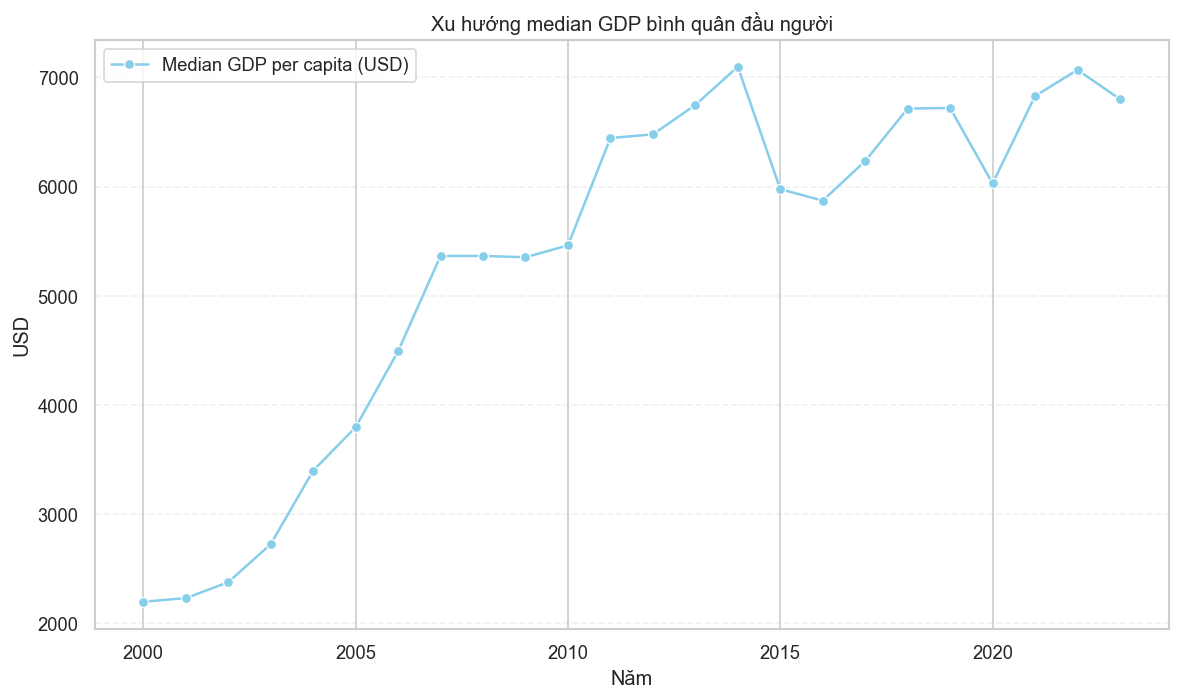

In [11]:
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.lineplot(
    data=gdp_trend,
    x="year",
    y="median_gdp_per_capita",
    marker="o",
    ax=ax1,
    color="skyblue",
    label="Median GDP per capita (USD)"
)
ax1.set_ylabel("USD")
ax1.set_xlabel("Năm")
ax1.set_title("Xu hướng median GDP bình quân đầu người")
ax1.grid(True, axis="y", linestyle="--", alpha=0.3)

plt.tight_layout()


### Insight:
- **Giai đoạn 2000-2008**: Median GDP tăng nhanh từ ~2,200 USD lên ~5,300 USD (+140%), phản ánh bước đệm kinh tế toàn cầu trước khủng hoảng 2008.
- **2008-2009**: Sụt giảm rõ rệt (từ 5,300 → 4,500 USD) do tác động của khủng hoảng tài chính toàn cầu.
- **2009-2013**: Hồi phục mạnh mẽ, tăng từ 4,500 → 6,500 USD, tuy nhiên tốc độ chậm hơn giai đoạn 2000-2008.
- **2013-2024**: Xu hướng biến động, dao động quanh 6,000-7,000 USD với các đỉnh (2013, 2021) và hẻm (2015, 2020), cho thấy sự không ổn định trong tăng trưởng kinh tế toàn cầu (khủng hoảng Eurozone, COVID-19).

### 4.3. Quan hệ giữa GDP bình quân và tuổi thọ
Ta sử dụng biểu đồ `regplot` để vẽ biểu đồ phân tán (scatter plot) kèm theo đường hồi quy, nhằm trực quan hóa mối quan hệ giữa hai thuộc tính.

Ở đây, ta sử dụng thang log ở trục X do đặc điểm của biến GDP (khoảng cách giàu nghèo giữa các quốc gia top đầu và quốc gia top cuối là rất lớn)


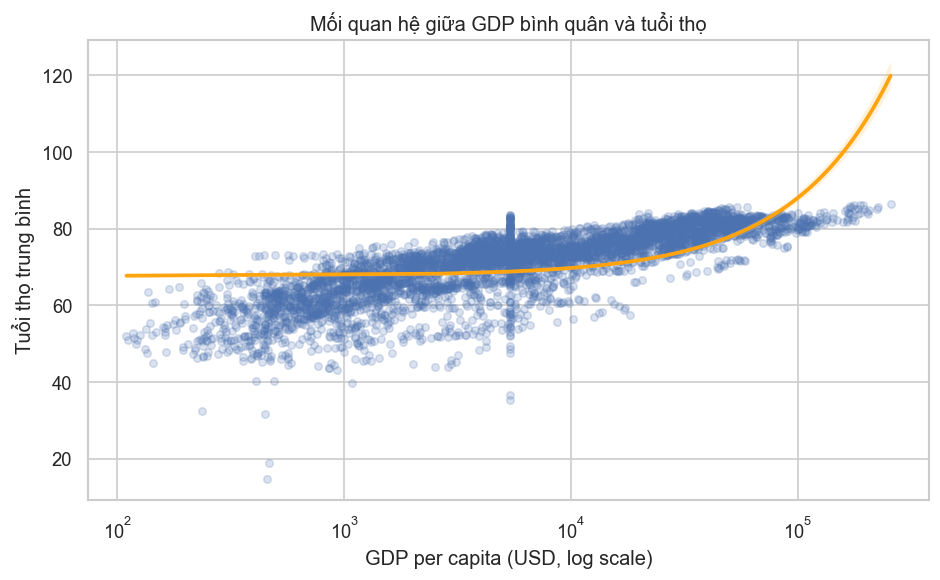

In [12]:
plt.figure(figsize=(8, 5))
sns.regplot(
    data=df,
    x="gdp_per_capita",
    y="life_expectancy",
    scatter_kws={"alpha": 0.2, "s": 20},
    line_kws={"color": "#ffa30e"}
)
plt.xscale("log")
plt.xlabel("GDP per capita (USD, log scale)")
plt.ylabel("Tuổi thọ trung bình")
plt.title("Mối quan hệ giữa GDP bình quân và tuổi thọ")
plt.tight_layout()


### Insight - Mối quan hệ GDP và Tuổi thọ (Log scale):
- **Quan hệ phi tuyến (Non-linear)**: Đường hồi quy cong lên, không phải đường thẳng, chứng tỏ tác động giảm dần của GDP.
- **Ngưỡng thấp (~$100-1,000)**: GDP tăng dù chỉ một chút cũng làm tuổi thọ tăng đáng kể (từ ~45 → 65 tuổi).
- **Ngưỡng cao (>$20,000)**: Tăng GDP thêm cũng tăng tuổi thọ nhưng không bao nhiêu (~65 → 80 tuổi). Sau ngưỡng $50,000, mối quan hệ gần như phẳng (R² thấp ở vùng cao).
- **Biến động lớn ở mỗi mức GDP**: Cho thấy yếu tố hạ tầng và y tế có tác động lớn bằng hoặc hơn GDP.

### 4.4. Phân tích các chỉ số hạ tầng cơ bản (`water_access`, `electricity`, `sanitation`)
Ta gộp dữ liệu theo từng năm, dữ liệu của các quốc gia khác nhau được tính trung vị (median) để phân tích xu hướng của các biến: `water_access`, `electricity` và `sanitation` theo thời gian.


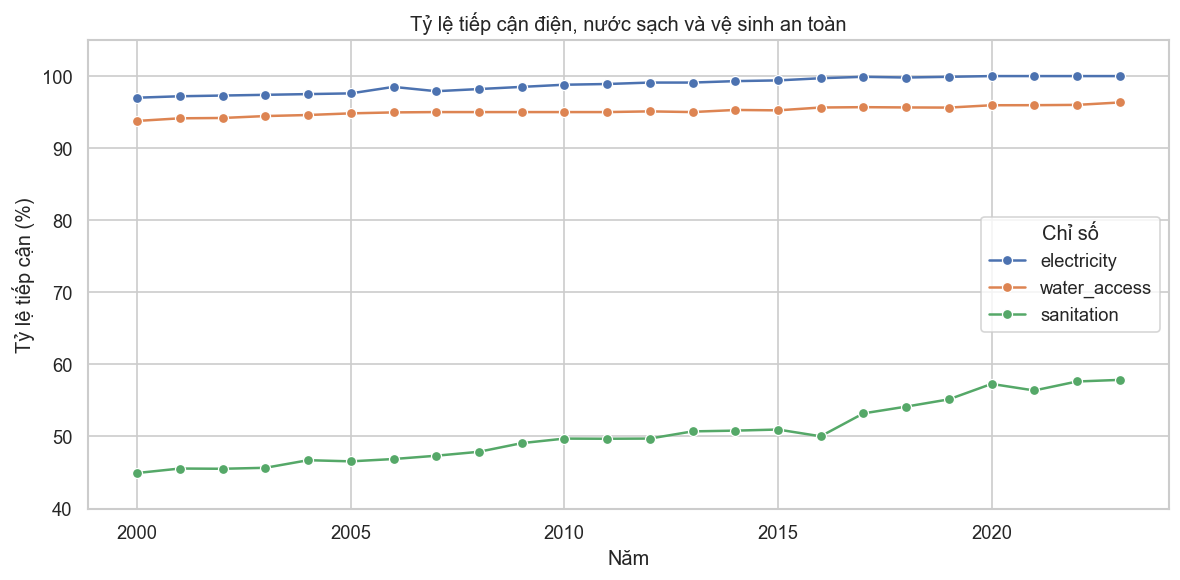

In [13]:
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=services_trend,
    x="year",
    y="coverage",
    hue="indicator",
    marker="o"
)
plt.ylim(40, 105)
plt.ylabel("Tỷ lệ tiếp cận (%)")
plt.xlabel("Năm")
plt.title("Tỷ lệ tiếp cận điện, nước sạch và vệ sinh an toàn")
plt.legend(title="Chỉ số")
plt.tight_layout()


### Insight - Xu hướng Hạ tầng cơ bản (2000-2024):
- **Electricity**: Tăng từ ~98% (2000) → ~100% (2024), gần bão hòa hoàn toàn. Gần như tất cả quốc gia đều tiếp cận được điện.
- **Water access**: Tăng từ ~93% (2000) → ~95% (2024), mức độ tăng chậm (~2 điểm). Vẫn còn ~5% dân số không có nước sạch.
- **Sanitation**: Tăng từ ~45% (2000) → ~56% (2024), **tăng chậm nhất chỉ 11 điểm** qua 24 năm. Gần một nửa dân số thế giới vẫn không có dịch vụ vệ sinh an toàn.
- **Kết luận**: Electricity và water_access đã gần bão hòa, nhưng **sanitation là nút thắt đòi hỏi đầu tư ưu tiên** để nâng tuổi thọ trong tương lai.

### 4.5. Mối quan hệ giữa hạ tầng cơ bản với tuổi thọ
Phân tích trực tiếp mức độ phủ `sanitation`, `water_access` và `electricity` so với `life_expectancy` để xem biến hạ tầng nào gắn với tuổi thọ mạnh nhất.


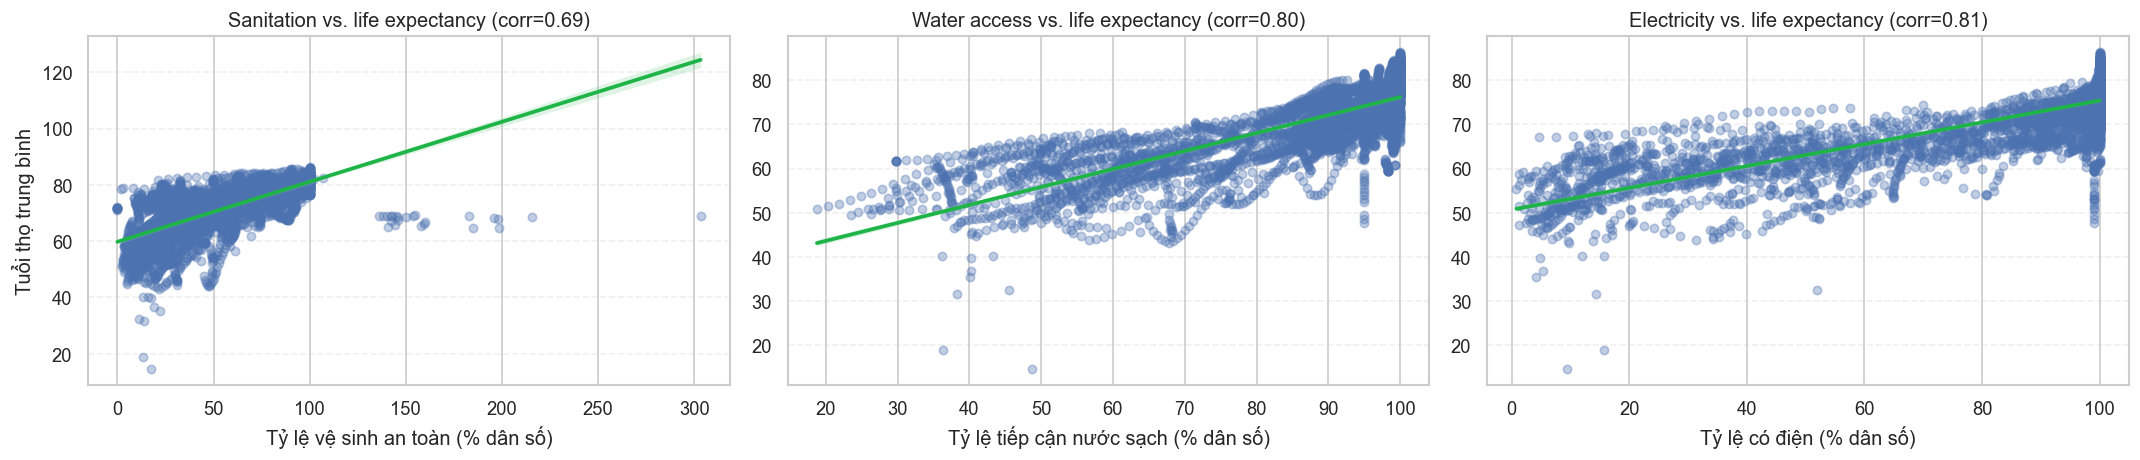

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

indicator_labels = {
    'sanitation': 'Tỷ lệ vệ sinh an toàn (% dân số)',
    'water_access': 'Tỷ lệ tiếp cận nước sạch (% dân số)',
    'electricity': 'Tỷ lệ có điện (% dân số)'
}
title_labels = {
    'sanitation': 'Sanitation vs. life expectancy',
    'water_access': 'Water access vs. life expectancy',
    'electricity': 'Electricity vs. life expectancy'
}

for ax, indicator in zip(axes, indicator_labels.keys()):
    sns.regplot(
        data=df,
        x=indicator,
        y='life_expectancy',
        scatter_kws={'alpha': 0.35, 's': 25},
        line_kws={'color': '#1fb447'},
        ax=ax
    )
    corr = df[[indicator, 'life_expectancy']].corr().iloc[0, 1]
    ax.set_title(f"{title_labels[indicator]} (corr={corr:.2f})")
    ax.set_xlabel(indicator_labels[indicator])
    ax.set_ylabel('Tuổi thọ trung bình' if indicator == 'sanitation' else '')
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()


### Insight - Mối quan hệ Hạ tầng vs Tuổi thọ:
**Tương quan từ mạnh đến trung bình**:
- **Electricity** (r=0.81): **Tương quan mạnh nhất**, quốc gia có >95% dân số tiếp cận điện thường có tuổi thọ >75 tuổi.
- **Water access** (r=0.80): **Tương quan mạnh bậc hai**, nước sạch là yếu tố cơ bản chống lại dịch bệnh.
- **Sanitation** (r=0.69): **Tương quan trung bình**, quốc gia có <50% dân số tiếp cận vệ sinh tập trung ở vùng tuổi thọ <70 tuổi.

**Nhóm nguy hiểm**: Các quốc gia có sanitation <30% thường có tuổi thọ <60 tuổi. Những quốc gia này cần được ưu tiên trong các chương trình hỗ trợ phát triển.

**Hiệu ứng kép**: Các quốc gia có cả ba chỉ số hạ tầng cao (>95%) đều có tuổi thọ cao (>80 tuổi), chứng tỏ hạ tầng là nền tảng chính để nâng chất lượng sống.

### 4.6. Top 10 quốc gia có GDP bình quân cao nhất (năm 2024)
Biểu đồ thanh ngang giúp xác định nhanh nhóm dẫn đầu để làm benchmark chính sách.


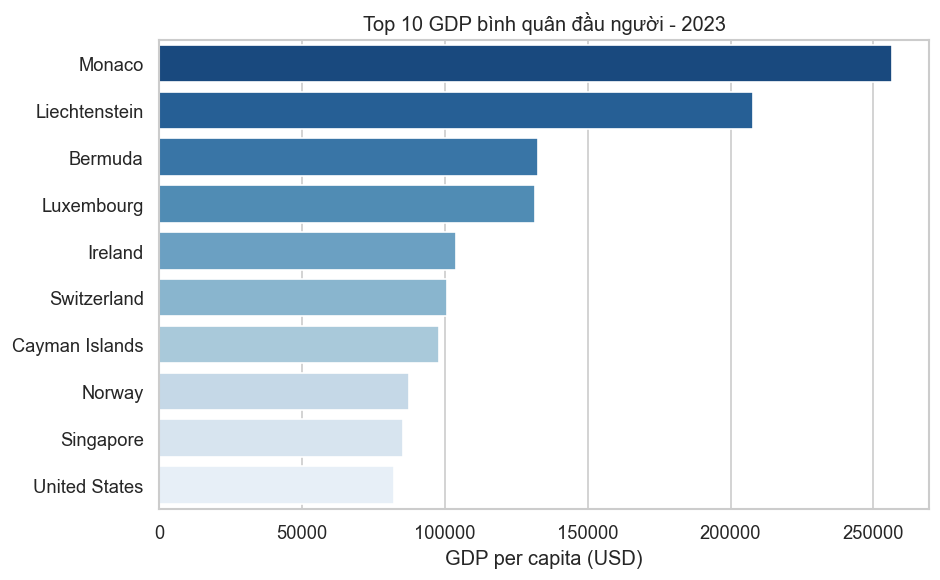

In [29]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=top_gdp_latest,
    x="gdp_per_capita",
    y="country_name",
    hue="country_name",
    palette="Blues_r",
    ax=ax
)
if ax.legend_ is not None:
    ax.legend_.remove()
ax.set_xlabel("GDP per capita (USD)")
ax.set_ylabel("")
ax.set_title(f"Top 10 GDP bình quân đầu người - {latest_year}")
plt.tight_layout()


### Insight - Top 10 GDP bình quân:
**Nhóm siêu giàu (>150,000 USD)**:
- **Monaco** (~250,000 USD): Nước nhỏ thứ nhân với nền kinh tế trọng điểm du lịch/tài chính.
- **Liechtenstein** (~220,000 USD): Quốc gia nhỏ với nền công nghiệp cao cấp.

**Nhóm giàu (100,000-150,000 USD)**:
- Bermuda, Luxembourg, Ireland: Các trung tâm tài chính/quốc gia thuế thấp.

**Nhóm giàu bậc hai (80,000-100,000 USD)**:
- Switzerland, Cayman Islands, Norway, Singapore: Các quốc gia phát triển với kinh tế cao cấp.
- **Mỹ** (~95,000 USD): Nền kinh tế lớn nhất thế giới, nhưng chỉ xếp thứ 10 theo bình quân đầu người.

**Khoảng cách**: Top 1 (Monaco) cao gấp **2.6 lần** Top 10 (USA), cho thấy **sự chênh lệch cực lớn** về sự giàu có giữa các quốc gia.

## Bước 5. Tổng kết các Insight chính

### **5.1. Tăng trưởng kinh tế và sự bất bình đẳng**
- Median GDP bình quân đầu người tăng **177%** (từ ~$2,200 năm 2000 → ~$6,500 năm 2024), chứng tỏ sự giàu có chung của thế giới tăng lên.
- **Tuy nhiên**, sự bất bình đẳng vẫn cực lớn: 10% quốc gia dưới $800 vs. 10% quốc gia >$45,000 (khoảng cách **56 lần**).
- Tốc độ tăng trưởng chậm lại sau 2013, chịu ảnh hưởng của nhiều cơn khủng hoảng toàn cầu.

### **5.2. Hạ tầng cơ bản: Một bức tranh hai màu**
- **Electricity & Water**: Gần bão hòa (~98-100% và ~95% tương ứng), cho thấy nhu cầu cơ bản này đã được đáp ứng ở hầu hết nơi.
- **Sanitation**: Chỉ ~56%, tăng chậm 11 điểm trong 24 năm. **Đây là nút thắt lớn nhất** cần được ưu tiên đầu tư.

### **5.3. Tuổi thọ: Phân hóa rõ rệt giữa các quốc gia**
- Median tuổi thọ ~72.6 tuổi, nhưng khoảng cách giữa 10% thấp nhất (~59 tuổi) và 10% cao nhất (>81 tuổi) là **22 tuổi**.
- Quốc gia có hạ tầng tốt (electricity >95%, water >90%, sanitation >80%) thường có tuổi thọ >80 tuổi.
- Quốc gia có sanitation <50% thường có tuổi thọ <70 tuổi, cho thấy sự gắn kết mạnh mẽ.

### **5.4. Những quốc gia giàu tích lũy lợi thế**
- Top 10 GDP bình quân có sẵn đủ tài nguyên để đầu tư vào y tế, hạ tầng, giáo dục, kéo tuổi thọ lên cao.
- Nhóm quốc gia này cũng có tốc độ tăng trưởng dân số thấp, cho thấy điều kiện sống tốt → ít sinh con → tuổi thọ cao.

## Kết luận

### **1. Mối quan hệ GDP-Tuổi thọ: Phi tuyến và có ngưỡng**
- GDP có tương quan dương với tuổi thọ (r ≈ +0.57) nhưng **không phải tuyến tính** trên toàn bộ phạm vi.
- **Ngưỡng nhạy cảm** (~$1,000-20,000 USD): GDP tăng 1,000 USD làm tuổi thọ tăng ~3-5 năm.
- **Ngưỡng bão hòa** (>$50,000 USD): Tác động GDP yếu đi đáng kể, bội số chi phí lợi ích giảm xuống.
- **Kết luận**: Ở các nước giàu, nâng tuổi thọ thêm đòi hỏi tập trung vào y tế/công nghệ cao chứ không phải chỉ tăng GDP.

### **2. Hạ tầng cơ bản là nền tảng chính (>GDP)**
- **Electricity** (r=0.81) và **Water access** (r=0.80) có tương quan **mạnh hơn GDP** với tuổi thọ, chứng tỏ nước sạch & điện là điều kiện cơ bản.
- Các quốc gia có electricity <50% thường có tuổi thọ <55 tuổi; water <50% → tuổi thọ <60 tuổi.
- **Sanitation** (r=0.69) cũng tương quan mạnh: quốc gia với vệ sinh <30% = tuổi thọ <55 tuổi (rất nguy hiểm).

### **3. Sanitation - Nút thắt lớn nhất cần giải quyết**
- Chỉ 56% dân số thế giới tiếp cận dịch vụ vệ sinh an toàn, tăng chậm chỉ 11 điểm trong 24 năm.
- Nếu cứ tốc độ này, cần **thêm 200+ năm** để toàn cầu bão hòa sanitation.
- **Ưu tiên nước ngoài là bắt buộc**: Viện trợ, đầu tư vào sanitation ở các nước <50% sẽ có ROI cao nhất về nâng tuổi thọ.

### **4. Sự bất bình đẳng kiên cố và khó thay đổi**
- Khoảng cách GDP 56:1, khoảng cách tuổi thọ 22 năm cho thấy sự "khóa" trong tình trạng:
  - Quốc gia nghèo → hạ tầng yếu → tuổi thọ thấp → giáo dục kém → lao động kém → vẫn nghèo.
  - Quốc gia giàu → hạ tầng tốt → tuổi thọ cao → giáo dục tốt → lao động cao → vẫn giàu.
- **Để phá vòng luẩn quẩn**: Cần đầu tư **nước ngoài** cắt ngang vào hạ tầng cơ bản (sanitation, nước, điện) ở nước nghèo, chứ không chỉ tuỳ thuộc vào GDP trong nước.

### **5. Tác động khủng hoảng toàn cầu**
- Xu hướng GDP chứng tỏ kinh tế thế giới dễ bị tổn thương (khủng hoảng 2008, Eurozone 2015, COVID-19 2020).
- Tuổi thọ tuy bình ổn hơn nhưng những quốc gia có kinh tế yếu sẽ bị ảnh hưởng trước. → Cần xây dựng hệ thống y tế toàn cầu bền vững.